### Check GPU hardware

In [ ]:
!nvidia-smi

Wed Dec 21 10:18:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download datasets and embeddings

In [ ]:
!wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Golden-standard-datasets/Pan-2010/pan_pairs.tsv
!wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Golden-standard-datasets/Pan-2010/pan_dict.tsv

# Download file seq2tensor.py for converting protein sequences to tensors
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/seq2tensor.py

!wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Dscript-data/pairs/human_train.tsv
!wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Dscript-data/seqs/human_dict.tsv

# Download file ac5_aph.txt for ac5_aph embedding 
!wget https://raw.githubusercontent.com/anhvt00/PIPR/master/embeddings/ac5_aph.txt



--2022-12-21 10:18:55--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Golden-standard-datasets/Pan-2010/pan_pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 990256 (967K) [text/plain]
Saving to: ‘pan_pairs.tsv’

pan_pairs.tsv       100%[===================>] 967.05K  --.-KB/s    in 0.007s  

2022-12-21 10:18:55 (127 MB/s) - ‘pan_pairs.tsv’ saved [990256/990256]

--2022-12-21 10:18:56--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Golden-standard-datasets/Pan-2010/pan_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, a

### Import libraries 

In [ ]:
# Libraries for system and debug
import sys
import pdb
import os
from datetime import datetime

# Class for converting sequences to tensors
from seq2tensor import s2t

# Libraries for neural network training
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Input, Conv1D, Conv2D
from tensorflow.keras.layers import Add, Flatten, subtract, multiply, concatenate
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence
from tensorflow.keras import mixed_precision
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, auc
import matplotlib.pyplot as plt

# Import accessory modules
import numpy as np
import h5py
import gc
from tqdm import tqdm


seq_size = 2000
dim = 13
N_EPOCHS = 100
BATCH_SIZE = 256
DTYPE='float16'

acc_list = []
recall_list = []
prec_list = []
spec_list = []
f1_list = []
mcc_list = []
auc_list = []
prc_list = []
dnn_fpr_list = []
dnn_tpr_list = []
dnn_fpr = []
dnn_tpr = []
dnn_prc_prec = []
dnn_prc_recall = []

### Set CUDA environment variables

In [ ]:
### Setting RAM GPU for training growth 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)





# ============================================
# Optimisation Flags - Do not remove
# ============================================

# Disables caching (when set to 1) or enables caching (when set to 0) for just-in-time-compilation. When disabled,
# no binary code is added to or retrieved from the cache.
os.environ['CUDA_CACHE_DISABLE'] = '0' # orig is 0

# When set to 1, forces the device driver to ignore any binary code embedded in an application 
# (see Application Compatibility) and to just-in-time compile embedded PTX code instead.
# If a kernel does not have embedded PTX code, it will fail to load. This environment variable can be used to
# validate that PTX code is embedded in an application and that its just-in-time compilation works as expected to guarantee application 
# forward compatibility with future architectures.
os.environ['CUDA_FORCE_PTX_JIT'] = '1'# no orig


os.environ['HOROVOD_GPU_ALLREDUCE'] = 'NCCL'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_GPU_THREAD_COUNT']='1'

os.environ['TF_USE_CUDNN_BATCHNORM_SPATIAL_PERSISTENT'] = '1'

os.environ['TF_ADJUST_HUE_FUSED'] = '1'
os.environ['TF_ADJUST_SATURATION_FUSED'] = '1'
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

os.environ['TF_SYNC_ON_FINISH'] = '0'
os.environ['TF_AUTOTUNE_THRESHOLD'] = '2'
os.environ['TF_DISABLE_NVTX_RANGES'] = '1'
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"



# =================================================
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs


### Architecture of PIPR

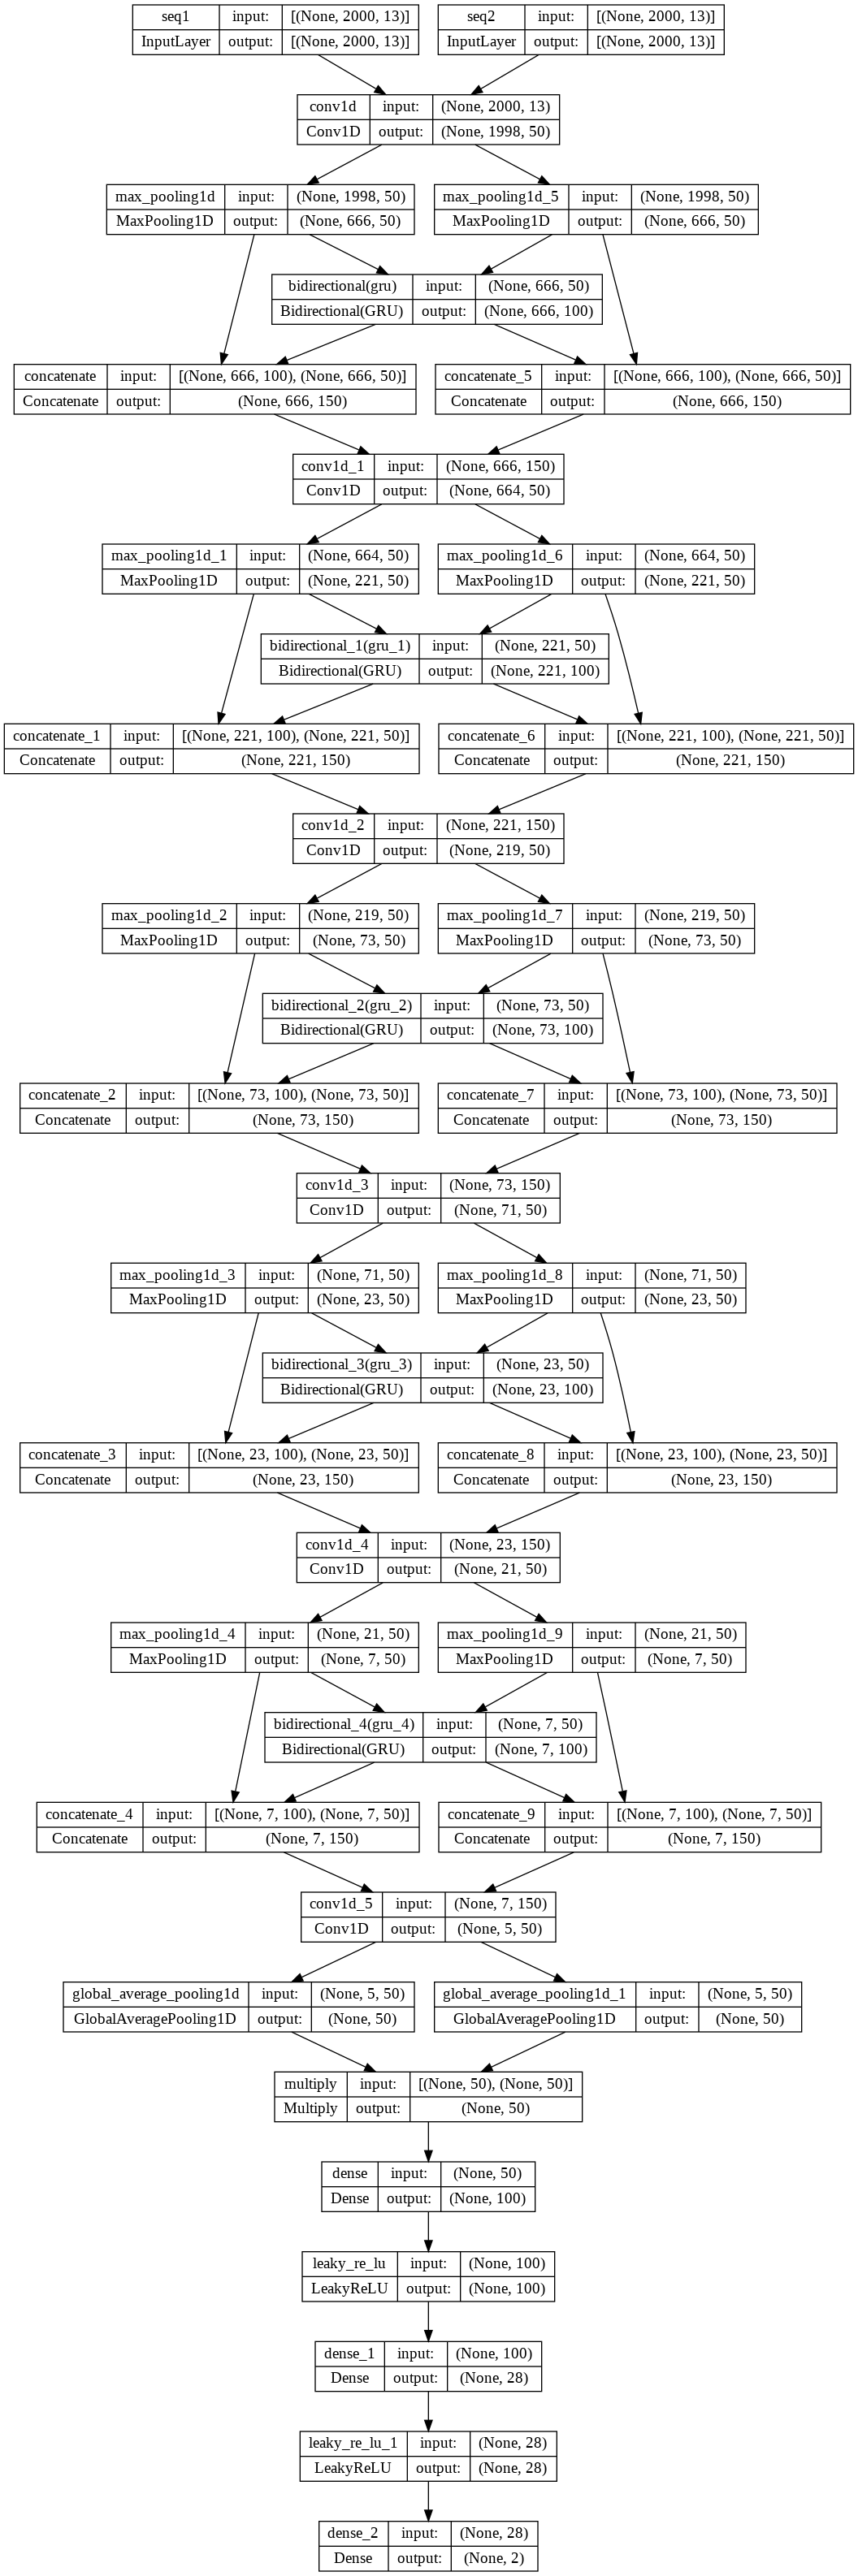

In [ ]:
def build_model():
    # Input of sequence tensor representations 
    seq_input1 = Input(shape=(seq_size, dim), name='seq1')
    seq_input2 = Input(shape=(seq_size, dim), name='seq2')

    # Define Conv1D and Bi-RNN (GRU/LSTM) use in architecture
    l1=Conv1D(50, 3)
    r1=Bidirectional(GRU(50, return_sequences=True))
    l2=Conv1D(50, 3)
    r2=Bidirectional(GRU(50, return_sequences=True))
    l3=Conv1D(50, 3)
    r3=Bidirectional(GRU(50, return_sequences=True))
    l4=Conv1D(50, 3)
    r4=Bidirectional(GRU(50, return_sequences=True))
    l5=Conv1D(50, 3)
    r5=Bidirectional(GRU(50, return_sequences=True))
    l6=Conv1D(50, 3)
    
    # Siamese architecture

    ### 1st sibling

    # 1st Block RCNN 
    s1=MaxPooling1D(3)(l1(seq_input1))
    s1=concatenate([r1(s1), s1])

    # 2nd Block RCNN
    s1=MaxPooling1D(3)(l2(s1))
    s1=concatenate([r2(s1), s1])

    # 3rd Block RCNN
    s1=MaxPooling1D(3)(l3(s1))
    s1=concatenate([r3(s1), s1])

    # 4th Block RCNN 
    s1=MaxPooling1D(3)(l4(s1))
    s1=concatenate([r4(s1), s1])

    # 5th Block RCNN
    s1=MaxPooling1D(3)(l5(s1))
    s1=concatenate([r5(s1), s1])
    
    # Last convolution
    s1=l6(s1)
    s1=GlobalAveragePooling1D()(s1)

    ### 2nd sibling

    # 1st block RCNN
    s2=MaxPooling1D(3)(l1(seq_input2))
    s2=concatenate([r1(s2), s2])

    # 2nd block RCNN
    s2=MaxPooling1D(3)(l2(s2))
    s2=concatenate([r2(s2), s2])

    # 3rd block RCNN
    s2=MaxPooling1D(3)(l3(s2))
    s2=concatenate([r3(s2), s2])

    # 4th block RCNN
    s2=MaxPooling1D(3)(l4(s2))
    s2=concatenate([r4(s2), s2])

    # 5th block RCNN
    s2=MaxPooling1D(3)(l5(s2))
    s2=concatenate([r5(s2), s2])

    # Last convolution
    s2=l6(s2)
    s2=GlobalAveragePooling1D()(s2)

    ### Combine two siblings of siamese architecture
    merge_text = multiply([s1, s2])
    

    #### MLP Part
    
    # First dense
    x = Dense(100)(merge_text)
    x = tf.keras.layers.LeakyReLU(alpha=.3)(x)

    # Second dense
    x = Dense(int((50+7)/2))(x)
    x = tf.keras.layers.LeakyReLU(alpha=.3)(x)

    # Last softmax
    main_output = Dense(2, activation='softmax')(x)

    # Combine to form functional model
    merge_model = Model(inputs=[seq_input1, seq_input2], outputs=[main_output])
    merge_model.compile(optimizer=Adam(learning_rate=.001, amsgrad=True, epsilon=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
    return merge_model

model = build_model()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Training phase

#### Read dataset file

In [ ]:
id2seq_file = 'pan_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'pan_pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


61891it [00:00, 472395.21it/s]
100%|██████████| 61891/61891 [00:00<00:00, 2149739.71it/s]


#### Create train dataset 

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]

In [ ]:
train_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
train_dataset = train_dataset.shuffle(BATCH_SIZE*4).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

#### Fit model on dataset

In [ ]:
# path='/content/PIPR_best_model_on_pan.hdf5'
merge_model = None
merge_model = build_model()
# if os.path.isfile(path):
  # merge_model.load_weights(path)
merge_model.compile(optimizer=Adam(learning_rate=.001, amsgrad=True, epsilon=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit model
for i in range(8):
  hist = merge_model.fit(train_dataset, epochs=5)

Epoch 1/5
242/242 [==============================] - 141s 440ms/step - loss: 0.6740 - accuracy: 0.5871
Epoch 2/5
242/242 [==============================] - 106s 435ms/step - loss: 0.6370 - accuracy: 0.6409
Epoch 3/5
242/242 [==============================] - 106s 435ms/step - loss: 0.2712 - accuracy: 0.8910
Epoch 4/5
242/242 [==============================] - 106s 434ms/step - loss: 0.1275 - accuracy: 0.9582
Epoch 5/5
242/242 [==============================] - 106s 434ms/step - loss: 0.0981 - accuracy: 0.9695
Epoch 1/5
242/242 [==============================] - 106s 435ms/step - loss: 0.0784 - accuracy: 0.9777
Epoch 2/5
242/242 [==============================] - 106s 437ms/step - loss: 0.0667 - accuracy: 0.9810
Epoch 3/5
242/242 [==============================] - 106s 437ms/step - loss: 0.0581 - accuracy: 0.9834
Epoch 4/5
242/242 [==============================] - 106s 435ms/step - loss: 0.0520 - accuracy: 0.9850
Epoch 5/5
242/242 [==============================] - 106s 434ms/step - lo

In [ ]:
merge_model.save('pipr_best_on_pan.hdf5')

In [ ]:
merge_model.load_weights('pipr_best_on_pan.hdf5')

## Inference phase

### Inference on intraspecies dataset (Human)

### HPRD

#### Read dataset

In [ ]:
id2seq_file = 'hprd_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'hprd_pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HPRD/hprd_pairs.tsv
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HPRD/hprd_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


3516it [00:00, 386031.43it/s]
100%|██████████| 3516/3516 [00:00<00:00, 2141616.74it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

14/14 [==============================] - 7s 135ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.9092718998862344, precision: 1.0, recall: 0.9092718998862344, specificity: 0.0 ,f1-score: 0.9524802621778639, mcc: nan, auc: nan, prc: 1.0
0.9092718998862344	1.0	0.9092718998862344	0.0	0.9524802621778639	nan	nan	1.0


### DIP

#### Read dataset

In [ ]:
id2seq_file = 'dip_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'dip_pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/DIP/dip_pairs.tsv
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/DIP/dip_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:12:42--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/DIP/dip_pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23488 (23K) [text/plain]
Saving to: ‘dip_pairs.tsv’

dip_pairs.tsv       100%[===================>]  22.94K  --.-KB/s    in 0.002s  

2022-12-21 06:12:42 (11.3 MB/s) - ‘dip_pairs.tsv’ saved [23488/23488]

--2022-12-21 06:12:42--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/DIP/dip_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

1468it [00:00, 314835.52it/s]
100%|██████████| 1468/1468 [00:00<00:00, 1314806.38it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

6/6 [==============================] - 1s 143ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.912125340599455, precision: 1.0, recall: 0.912125340599455, specificity: 0.0 ,f1-score: 0.9540434627716424, mcc: nan, auc: nan, prc: 1.0
0.912125340599455	1.0	0.912125340599455	0.0	0.9540434627716424	nan	nan	1.0


### HIPPIE HQ


#### Read dataset

In [ ]:
id2seq_file = 'hiphq_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'hiphq_pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/HQ/hiphq_dict.tsv
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/HQ/hiphq_pairs.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:12:45--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/HQ/hiphq_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4151340 (4.0M) [text/plain]
Saving to: ‘hiphq_dict.tsv’

hiphq_dict.tsv      100%[===================>]   3.96M  --.-KB/s    in 0.09s   

2022-12-21 06:12:46 (44.1 MB/s) - ‘hiphq_dict.tsv’ saved [4151340/4151340]

--2022-12-21 06:12:46--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/HQ/hiphq_pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... conne

15489it [00:00, 420818.73it/s]
100%|██████████| 15489/15489 [00:00<00:00, 1989087.13it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

61/61 [==============================] - 9s 130ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.9059332429466073, precision: 1.0, recall: 0.9059332429466073, specificity: 0.0 ,f1-score: 0.9506453033433826, mcc: nan, auc: nan, prc: 1.0
0.9059332429466073	1.0	0.9059332429466073	0.0	0.9506453033433826	nan	nan	1.0


### HIPPIE LQ


#### Read dataset

In [ ]:
id2seq_file = 'hiplq_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'hiplq_pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/LQ/hiplq_dict.tsv
  !wget https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/LQ/hiplq_pairs.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:12:59--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/LQ/hiplq_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6837915 (6.5M) [text/plain]
Saving to: ‘hiplq_dict.tsv’

hiplq_dict.tsv      100%[===================>]   6.52M  --.-KB/s    in 0.1s    

2022-12-21 06:13:00 (50.2 MB/s) - ‘hiplq_dict.tsv’ saved [6837915/6837915]

--2022-12-21 06:13:00--  https://raw.githubusercontent.com/anhvt00/S-HNBM/master/data/Independent-testsets/Human-sets/HIPPIE/LQ/hiplq_pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

101684it [00:00, 164158.68it/s]
100%|██████████| 101684/101684 [00:00<00:00, 2018149.94it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

398/398 [==============================] - 52s 127ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.9034066323118681, precision: 1.0, recall: 0.9033967979229771, specificity: 0.0 ,f1-score: 0.9492469451548736, mcc: nan, auc: nan, prc: 1.0
0.9034066323118681	1.0	0.9033967979229771	0.0	0.9492469451548736	nan	nan	1.0


### Inference on cross-species datasets

### E. coli


#### Read dataset

In [ ]:
id2seq_file = 'ecoli_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'ecoli_test.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/ecoli_test.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/ecoli_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:14:00--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/ecoli_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 768468 (750K) [text/plain]
Saving to: ‘ecoli_test.tsv’

ecoli_test.tsv      100%[===================>] 750.46K  --.-KB/s    in 0.05s   

2022-12-21 06:14:01 (13.8 MB/s) - ‘ecoli_test.tsv’ saved [768468/768468]

--2022-12-21 06:14:01--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/ecoli_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTT

22000it [00:00, 440489.82it/s]
100%|██████████| 22000/22000 [00:00<00:00, 1943197.74it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

86/86 [==============================] - 11s 127ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.14477272727272728, precision: 0.08306471609223903, recall: 0.8375, specificity: 0.8228882833787466 ,f1-score: 0.1511391833972479, mcc: -0.0710791815817969, auc: 0.4141013125, prc: 0.07651187005188066
0.14477272727272728	0.08306471609223903	0.8375	0.8228882833787466	0.1511391833972479	-0.0710791815817969	0.4141013125	0.07651187005188066


### Fly


#### Read dataset

In [ ]:
id2seq_file = 'fly_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'fly_test.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/fly_test.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/fly_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:14:17--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/fly_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1980000 (1.9M) [text/plain]
Saving to: ‘fly_test.tsv’

fly_test.tsv        100%[===================>]   1.89M  --.-KB/s    in 0.07s   

2022-12-21 06:14:18 (27.6 MB/s) - ‘fly_test.tsv’ saved [1980000/1980000]

--2022-12-21 06:14:18--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/fly_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP req

55000it [00:00, 418805.24it/s]
100%|██████████| 55000/55000 [00:00<00:00, 2032177.74it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

215/215 [==============================] - 29s 124ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.13318181818181818, precision: 0.08706674665686141, recall: 0.8998, specificity: 0.8494138863841298 ,f1-score: 0.15877049035696011, mcc: -0.03695757514871251, auc: 0.430104, prc: 0.07874267356685488
0.13318181818181818	0.08706674665686141	0.8998	0.8494138863841298	0.15877049035696011	-0.03695757514871251	0.430104	0.07874267356685488


### Mouse


#### Read dataset

In [ ]:
id2seq_file = 'mouse_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'mouse_test.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/mouse_test.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/mouse_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


55000it [00:00, 346905.67it/s]
100%|██████████| 55000/55000 [00:00<00:00, 1455960.31it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

215/215 [==============================] - 38s 125ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.1343090909090909, precision: 0.08682245709298943, recall: 0.8954, specificity: 0.8477438136826783 ,f1-score: 0.15829576593299743, mcc: -0.03908111507915987, auc: 0.46004621800000006, prc: 0.0839567418757015
0.1343090909090909	0.08682245709298943	0.8954	0.8477438136826783	0.15829576593299743	-0.03908111507915987	0.46004621800000006	0.0839567418757015


### Worm


#### Read dataset

In [ ]:
id2seq_file = 'worm_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'worm_test.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/worm_test.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/worm_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


55000it [00:00, 132288.68it/s]
100%|██████████| 55000/55000 [00:00<00:00, 1927642.16it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

215/215 [==============================] - 37s 125ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.12303636363636364, precision: 0.08645163758800123, recall: 0.9038, specificity: 0.8236803519061584 ,f1-score: 0.1578083531219444, mcc: -0.04486482415874405, auc: 0.419656892, prc: 0.07734786532697413
0.12303636363636364	0.08645163758800123	0.9038	0.8236803519061584	0.1578083531219444	-0.04486482415874405	0.419656892	0.07734786532697413


### Yeast


#### Read dataset

In [ ]:
id2seq_file = 'yeast_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'yeast_test.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/yeast_test.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/yeast_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:21:14--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/pairs/yeast_test.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556676 (1.5M) [text/plain]
Saving to: ‘yeast_test.tsv’

yeast_test.tsv      100%[===================>]   1.48M  --.-KB/s    in 0.07s   

2022-12-21 06:21:14 (22.4 MB/s) - ‘yeast_test.tsv’ saved [1556676/1556676]

--2022-12-21 06:21:15--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/cross-species/seqs/yeast_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.


55000it [00:00, 392158.95it/s]
100%|██████████| 55000/55000 [00:00<00:00, 2063313.66it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

215/215 [==============================] - 29s 131ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.13652727272727272, precision: 0.08570425693726721, recall: 0.879, specificity: 0.8373218607152461 ,f1-score: 0.1561805938060802, mcc: -0.049165373397026396, auc: 0.43352650400000003, prc: 0.07943591585190962
0.13652727272727272	0.08570425693726721	0.879	0.8373218607152461	0.1561805938060802	-0.049165373397026396	0.43352650400000003	0.07943591585190962


### Guo-2008


#### Read dataset

In [ ]:
id2seq_file = 'guo_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'guo_pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Guo-2008/guo_pairs.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Guo-2008/guo_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:21:47--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Guo-2008/guo_pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179008 (175K) [text/plain]
Saving to: ‘guo_pairs.tsv’

guo_pairs.tsv       100%[===================>] 174.81K  --.-KB/s    in 0.03s   

2022-12-21 06:21:48 (5.58 MB/s) - ‘guo_pairs.tsv’ saved [179008/179008]

--2022-12-21 06:21:48--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Guo-2008/guo_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, aw

11188it [00:00, 437716.85it/s]
100%|██████████| 11188/11188 [00:00<00:00, 2138047.80it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

44/44 [==============================] - 6s 130ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.5013407222023597, precision: 0.500710429099176, recall: 0.9449410082230961, specificity: 0.5118858954041204 ,f1-score: 0.6545724722927374, mcc: 0.0026814540447571544, auc: 0.4920608026706176, prc: 0.4947748400546665
0.5013407222023597	0.500710429099176	0.9449410082230961	0.5118858954041204	0.6545724722927374	0.0026814540447571544	0.4920608026706176	0.4947748400546665


### Martin-2005


#### Read dataset

In [ ]:
id2seq_file = 'martin_dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'martin_pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Martin-2005/martin_pairs.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Martin-2005/martin_dict.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:21:57--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Martin-2005/martin_pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39040 (38K) [text/plain]
Saving to: ‘martin_pairs.tsv’

martin_pairs.tsv    100%[===================>]  38.12K  --.-KB/s    in 0.02s   

2022-12-21 06:21:57 (2.13 MB/s) - ‘martin_pairs.tsv’ saved [39040/39040]

--2022-12-21 06:21:58--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Golden-standard-datasets/Martin-2005/martin_dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP re

2878it [00:00, 392470.23it/s]
100%|██████████| 2878/2878 [00:00<00:00, 1869186.58it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

12/12 [==============================] - 2s 139ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.4975677553856845, precision: 0.4951744617668894, recall: 0.9394366197183098, specificity: 0.532608695652174 ,f1-score: 0.6485172581429265, mcc: 0.006651482064900441, auc: 0.5266559921945941, prc: 0.5108383906523467
0.4975677553856845	0.4951744617668894	0.9394366197183098	0.532608695652174	0.6485172581429265	0.006651482064900441	0.5266559921945941	0.5108383906523467


### Chen-2019 Multi-species


#### Read dataset

In [ ]:
id2seq_file = 'dict.tsv'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'pairs.tsv'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/multi-species/dict.tsv
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/multi-species/pairs.tsv


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:22:01--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/multi-species/dict.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5878871 (5.6M) [text/plain]
Saving to: ‘dict.tsv’

dict.tsv            100%[===================>]   5.61M  --.-KB/s    in 0.09s   

2022-12-21 06:22:02 (59.5 MB/s) - ‘dict.tsv’ saved [5878871/5878871]

--2022-12-21 06:22:02--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Independent-testsets/multi-species/pairs.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respon

65918it [00:00, 121408.75it/s]
100%|██████████| 65918/65918 [00:00<00:00, 2014119.01it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

258/258 [==============================] - 34s 127ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.5081464850268516, precision: 0.5044685710502796, recall: 0.9248156800873812, specificity: 0.5491266375545851 ,f1-score: 0.6528308756599308, mcc: 0.016386191695721974, auc: 0.5106145326743685, prc: 0.5055447950188481
0.5081464850268516	0.5044685710502796	0.9248156800873812	0.5491266375545851	0.6528308756599308	0.016386191695721974	0.5106145326743685	0.5055447950188481


## Inference on inter-species datasets

### DENV


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/DENV/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/DENV/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:22:44--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/DENV/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316639 (309K) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>] 309.22K  --.-KB/s    in 0.04s   

2022-12-21 06:22:44 (7.64 MB/s) - ‘protein_pair_label.txt’ saved [316639/316639]

--2022-12-21 06:22:44--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/DENV/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.10

10197it [00:00, 183074.51it/s]
100%|██████████| 10197/10197 [00:00<00:00, 2236655.05it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

40/40 [==============================] - 6s 131ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.15318230852211434, precision: 0.07592429577464789, recall: 0.7443365695792881, specificity: 0.7862939585211902 ,f1-score: 0.1377933100349476, mcc: -0.12898527313132854, auc: 0.3983339908230723, prc: 0.07490886213035082
0.15318230852211434	0.07592429577464789	0.7443365695792881	0.7862939585211902	0.1377933100349476	-0.12898527313132854	0.3983339908230723	0.07490886213035082


### HIV


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/HIV/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/HIV/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:22:57--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/HIV/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1797825 (1.7M) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>]   1.71M  --.-KB/s    in 0.07s   

2022-12-21 06:22:57 (25.3 MB/s) - ‘protein_pair_label.txt’ saved [1797825/1797825]

--2022-12-21 06:22:57--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/HIV/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.1

108680it [00:00, 223940.62it/s]
100%|██████████| 108680/108680 [00:00<00:00, 1956852.11it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

425/425 [==============================] - 56s 126ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.1382315053367685, precision: 0.09175080893532415, recall: 0.952834008097166, specificity: 0.9233048057932851 ,f1-score: 0.16738380569681022, mcc: 0.008008718247810503, auc: 0.5240984470528939, prc: 0.09567330995797613
0.1382315053367685	0.09175080893532415	0.952834008097166	0.9233048057932851	0.16738380569681022	0.008008718247810503	0.5240984470528939	0.09567330995797613


### Hepatitis


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Hepatitis/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Hepatitis/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:24:08--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Hepatitis/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342539 (335K) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>] 334.51K  --.-KB/s    in 0.04s   

2022-12-21 06:24:08 (8.37 MB/s) - ‘protein_pair_label.txt’ saved [342539/342539]

--2022-12-21 06:24:09--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Hepatitis/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

14300it [00:00, 378246.50it/s]
100%|██████████| 14300/14300 [00:00<00:00, 2025617.94it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

56/56 [==============================] - 8s 131ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.15104895104895105, precision: 0.09119022476995021, recall: 0.93, specificity: 0.9126679462571977 ,f1-score: 0.16609424371479597, mcc: 0.0025319063487784627, auc: 0.5184400887573962, prc: 0.09485302047584714
0.15104895104895105	0.09119022476995021	0.93	0.9126679462571977	0.16609424371479597	0.0025319063487784627	0.5184400887573962	0.09485302047584714


### Herpes


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Herpes/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Herpes/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:24:25--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Herpes/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1056464 (1.0M) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>]   1.01M  --.-KB/s    in 0.06s   

2022-12-21 06:24:25 (17.3 MB/s) - ‘protein_pair_label.txt’ saved [1056464/1056464]

--2022-12-21 06:24:26--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Herpes/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

65626it [00:00, 376733.96it/s]
100%|██████████| 65626/65626 [00:00<00:00, 2111420.97it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

257/257 [==============================] - 35s 127ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.1268247340992899, precision: 0.089312, recall: 0.9356352665102247, specificity: 0.8771593090211133 ,f1-score: 0.1630590366021091, mcc: -0.015898326589499207, auc: 0.48513132552786264, prc: 0.08835222263568408
0.1268247340992899	0.089312	0.9356352665102247	0.8771593090211133	0.1630590366021091	-0.015898326589499207	0.48513132552786264	0.08835222263568408


### Influenza


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Influenza/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Influenza/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:25:14--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Influenza/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538680 (526K) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>] 526.05K  --.-KB/s    in 0.05s   

2022-12-21 06:25:15 (10.1 MB/s) - ‘protein_pair_label.txt’ saved [538680/538680]

--2022-12-21 06:25:16--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Influenza/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

33484it [00:00, 90185.37it/s]
100%|██████████| 33484/33484 [00:00<00:00, 2010451.14it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

131/131 [==============================] - 19s 130ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.1523414167960817, precision: 0.08917280067447064, recall: 0.9034165571616294, specificity: 0.8888468809073724 ,f1-score: 0.1623232889649677, mcc: -0.01547955545681099, auc: 0.4830823890862186, prc: 0.0878169480690402
0.1523414167960817	0.08917280067447064	0.9034165571616294	0.8888468809073724	0.1623232889649677	-0.01547955545681099	0.4830823890862186	0.0878169480690402


### Papilloma


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Papilloma/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Papilloma/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:37:50--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Papilloma/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 909090 (888K) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>] 887.78K  --.-KB/s    in 0.05s   

2022-12-21 06:37:50 (15.9 MB/s) - ‘protein_pair_label.txt’ saved [909090/909090]

--2022-12-21 06:37:50--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/Papilloma/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

56089it [00:00, 141934.59it/s]
100%|██████████| 56089/56089 [00:00<00:00, 2007357.91it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

220/220 [==============================] - 30s 128ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.12972240546274671, precision: 0.0905855467725621, recall: 0.948421259070406, specificity: 0.9027007029226785 ,f1-score: 0.16537573736855607, mcc: -0.003188155574991697, auc: 0.4748923482145114, prc: 0.08633401423475827
0.12972240546274671	0.0905855467725621	0.948421259070406	0.9027007029226785	0.16537573736855607	-0.003188155574991697	0.4748923482145114	0.08633401423475827


### SARS2


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/SARS2/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/SARS2/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:38:32--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/SARS2/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157705 (154K) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>] 154.01K  --.-KB/s    in 0.03s   

2022-12-21 06:38:32 (5.37 MB/s) - ‘protein_pair_label.txt’ saved [157705/157705]

--2022-12-21 06:38:33--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/SARS2/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.

6248it [00:00, 381023.17it/s]
100%|██████████| 6248/6248 [00:00<00:00, 2079842.17it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

25/25 [==============================] - 4s 132ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.11187580025608194, precision: 0.08990614193973324, recall: 0.9612676056338029, specificity: 0.8742857142857143 ,f1-score: 0.16443306730914017, mcc: -0.010757933426960565, auc: 0.5076107171196192, prc: 0.0925317244848024
0.11187580025608194	0.08990614193973324	0.9612676056338029	0.8742857142857143	0.16443306730914017	-0.010757933426960565	0.5076107171196192	0.0925317244848024


### ZIKA


#### Read dataset

In [ ]:
!rm -rf pro_seq.txt protein_pair_label.txt
id2seq_file = 'pro_seq.txt'
id2index = {}
seqs = []
index = 0
sid1_index = 0
sid2_index = 1
ds_file = 'protein_pair_label.txt'
label_index = 2
use_emb = 'ac5_aph.txt'

if not os.path.isfile(ds_file) or not os.path.isfile(id2seq_file):
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/ZIKV/protein_pair_label.txt
  !wget https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/ZIKV/pro_seq.txt


# Create line variable as a list of protein sequences with index is the number of protein sequences
# id2index is a dictionary of protein id and incremental index number 
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1

seq_array = []
id2_aid = {}
sid = 0

seq2t = s2t(use_emb)

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = False
x = None
count = 0

# Create sequence array as a list of protein strings
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
dim = seq2t.dim

# seq_tensor is tensor representation of dataset having shape of (number_of_sequences, padding_length, embedding_dim_of_aa)
# Random for distribution of class labels
np.random.seed(42)
np.random.shuffle(raw_data)
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])

# Extract index of 1st and 2nd sequences in pairs
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])

# Assign labels for pairs of sequences
class_map = {'0':1,'1':0}
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1


--2022-12-21 06:38:41--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/ZIKV/protein_pair_label.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257373 (251K) [text/plain]
Saving to: ‘protein_pair_label.txt’

protein_pair_label. 100%[===================>] 251.34K  --.-KB/s    in 0.04s   

2022-12-21 06:38:41 (6.25 MB/s) - ‘protein_pair_label.txt’ saved [257373/257373]

--2022-12-21 06:38:42--  https://raw.githubusercontent.com/anhvt00/MCAPS/master/data/Interspecies-host-pathogen/human-virus/ZIKV/pro_seq.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.10

7799it [00:00, 306065.64it/s]
100%|██████████| 7799/7799 [00:00<00:00, 2245118.52it/s]


#### Create test dataset

In [ ]:
def generator_pair_general(seq_tensor, seq_index1, seq_index2, class_labels):
  for index in range(len(seq_index1)):
    yield {"seq1": seq_tensor[seq_index1[index]], "seq2": seq_tensor[seq_index2[index]]}, class_labels[index]
pred_dataset = tf.data.Dataset.from_generator(generator_pair_general, args=[seq_tensor, seq_index1, seq_index2, class_labels], output_types=({"seq1": DTYPE, "seq2": DTYPE}, DTYPE), output_shapes = ({"seq1": (seq_size, dim), "seq2": (seq_size, dim)}, (2,)) )
pred_dataset = pred_dataset.batch(BATCH_SIZE)
pred_dataset = pred_dataset.prefetch(tf.data.AUTOTUNE)
pred = merge_model.predict(pred_dataset)

31/31 [==============================] - 5s 133ms/step


#### Inference on test dataset

In [ ]:
# Use for average score
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

# # Performance metrics
for i in range(len(class_labels)):
    num_total += 1
    if np.argmax(class_labels[i]) == np.argmax(pred[i]):
        num_hit += 1
    if class_labels[i][0] > 0.:
        num_pos += 1.
        if pred[i][0] > pred[i][1]:
            num_true_pos += 1              
        else:                  
            num_false_neg += 1
    else:
        if pred[i][0] > pred[i][1]:
            num_false_pos += 1
        else:
            num_true_neg += 1

accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)

try:
  mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
except ZeroDivisionError:
  mcc = 'nan'

try:
  auc = roc_auc_score(class_labels[:,0], pred[:,0])
except ValueError:
  auc = 'nan'
prc = average_precision_score(class_labels[:,0], pred[:,0])

print("======================= manual compute ==============")
print (f'accuracy: {accuracy}, precision: {prec}, recall: {recall}, specificity: {spec} ,f1-score: {f1}, mcc: {mcc}, auc: {auc}, prc: {prc}')

print(str(accuracy) + "\t" + str(prec) + "\t" + str(recall) + "\t" + str(spec) + "\t" + str(f1) + '\t' + str(mcc) + '\t' + str(auc) + '\t' + str(prc))


======================= manual compute ==============
accuracy: 0.1200153865880241, precision: 0.09006128430588863, recall: 0.9534555712270804, specificity: 0.8873720136518771 ,f1-score: 0.16457699330493, mcc: -0.008733797458949467, auc: 0.48941227140074917, prc: 0.08889833591983827
0.1200153865880241	0.09006128430588863	0.9534555712270804	0.8873720136518771	0.16457699330493	-0.008733797458949467	0.48941227140074917	0.08889833591983827
